In [2]:
from pathlib import Path 

import numpy as np 
import matplotlib.pyplot as plt 
import scipy

import CompPhy as cp 

plt.style.use("custom.matplotlibrc")

DIR = (Path("./") / "Exercise_6").resolve()

def generate_checkerboard(N: int):
    b1 = np.array([-1, 1] * (N // 2))
    b2 = np.array([1, -1] * (N // 2))
    return np.array([b1, b2] * (N // 2))

# 1. Spontaneous Magnetization

In [2]:
np.random.seed(1)
j_scan = dict()

J = [0.1, 0.2, 0.5 * np.log(1 + np.sqrt(2)), 0.7, 0.8]
def do_j_scan(N: int, SAMPLE_SIZE: int):

    b1 = np.array([-1, 1] * (N // 2))
    b2 = np.array([1, -1] * (N // 2))
    start_cfg = np.array([b1, b2] * (N // 2))

    fig, ax = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

    color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for i, j in enumerate(J):
        model = cp.Ising2D(lattice_sites=N, j=j, h=0)

        sample = model.generate_sample(SAMPLE_SIZE, start_cfg)
        m = np.abs(sample.mean(axis = (1, 2)))
        j_scan[f"{N} {j}"] = m

        ax[i].hist(m, density=True, bins=10, label=f"$J = {"{:.2f}".format(j)}$", orientation="horizontal", color=color_cycle[i])
        ax[i].legend(frameon=True)

    fig.supxlabel("PDF")
    # fig.suptitle(f"$N = {N}$")
    fig.savefig(DIR / f"j_scan_{N}.pdf")


KeyboardInterrupt: 

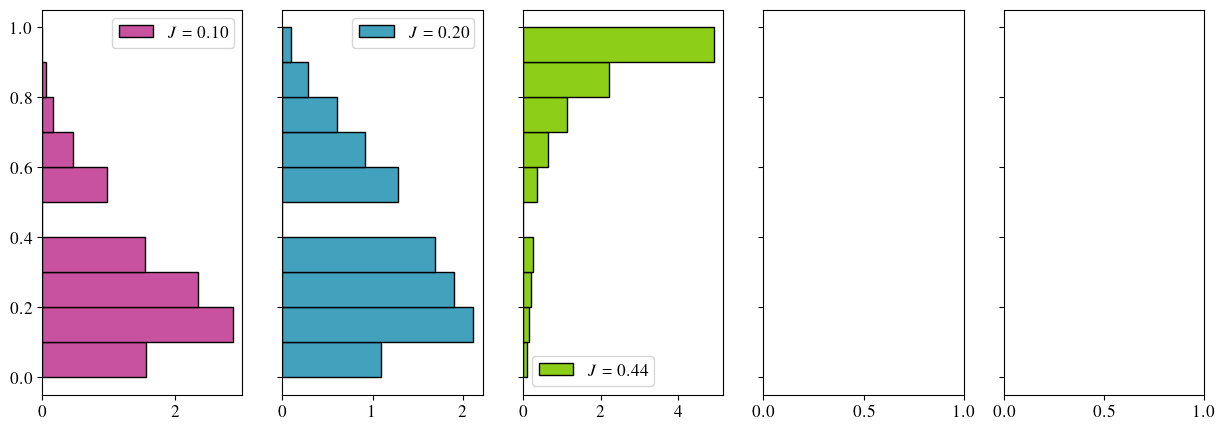

In [65]:
np.random.seed(2)
for N in [4, 8, 12]:
    do_j_scan(N, 10_000)

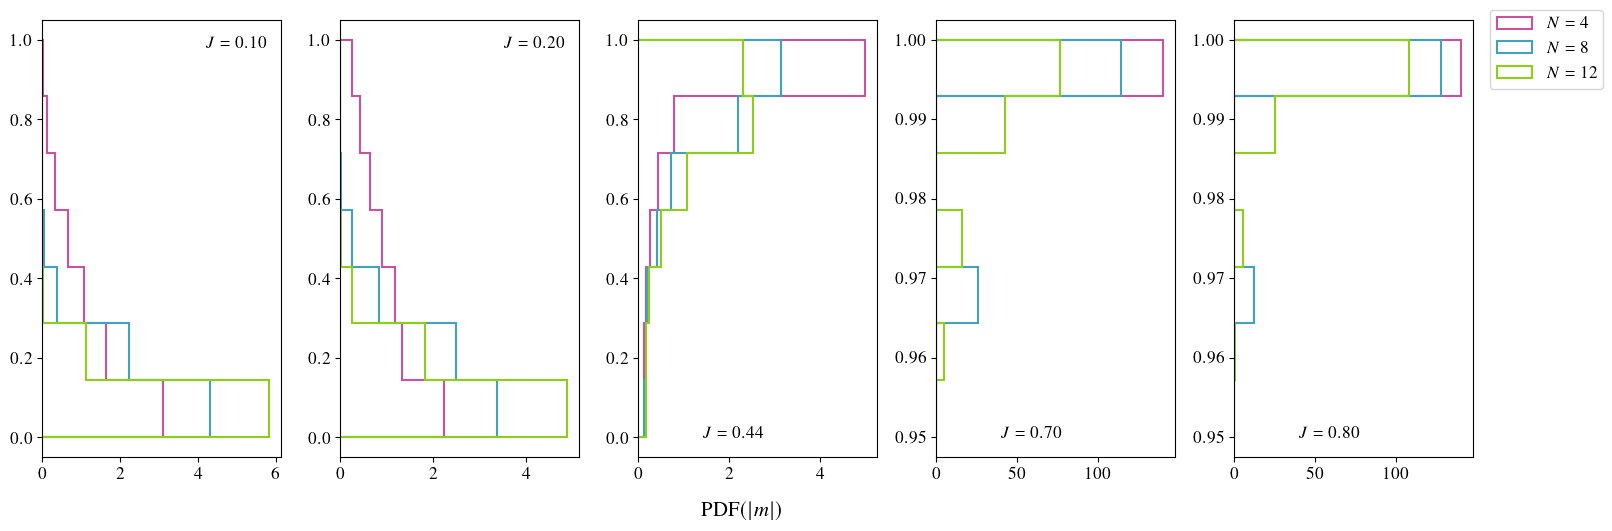

In [ ]:
# fig, ax = plt.subplots(1, len(J), figsize=(15, 5))
fig = plt.figure(1, figsize=(15, 5))
handles, labels = [], []
ax = None
for i, j in enumerate(J):
    for N in [4, 8, 12]:
        m = j_scan[f"{N} {j}"]
        if i < 6:
            ax = plt.subplot(1, 5, i + 1)
            rng = (0, 1)
            if i > 2:
                rng = (0.95, 1)
            plt.hist(m, label=f"$N = {N}$", density=True, orientation="horizontal", alpha=1, histtype="step", bins=7, range=rng, lw=1.5)
            plt.legend(handles=[plt.Line2D([0], [0], label=f"$J = {"{:.2f}".format(j)}$", linestyle="")], frameon=False)
        # else:
        #     plt.subplot(2, 5, i + 1)
        #     plt.hist(m, label=f"$N = {N}$", density=True, orientation="horizontal", alpha=1, histtype="step", bins=15, range=(0.75, 1))
        #     plt.subplot(2, 5, i + 6)
        #     plt.hist(m, label=f"$N = {N}$", density=True, orientation="horizontal", alpha=1, histtype="step", bins=15, range=(-1, -0.75))

fig.tight_layout()
# lgd = fig.legend()
# handles, labels = lgd.legend_handles[:3], lgd.legend_labels[:3]
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.08, 1))
fig.supxlabel(r"$\text{PDF}(\abs{m})$", y = -0.04)
fig.savefig(DIR / "j_scan_compare_n.pdf", bbox_inches="tight")
    

# 2. Scanning $J$

## Exact Results

In [3]:
J_c = 0.5 * np.log(1 + np.sqrt(2))
@np.vectorize
def mean_mag_per_site(J):

    if J <= J_c:
        return 0

    return np.power(1 - 1 / np.sinh(2 * J) ** 4, 0.125)


def mean_energy_per_site(J):
    tanh2 = np.tanh(2 * J) ** 2
    fac = -J * np.cosh(2 * J) / np.sinh(2 * J)
    term1 = 2 * tanh2 - 1
    term2 = scipy.special.ellipk(4 * (1 - tanh2) * tanh2)

    return fac * (1 + 2 / np.pi * term1 * term2)

## Generate Ensembles

In [4]:
from multiprocessing import Pool, cpu_count

np.random.seed(10)
N = [4, 8, 12]
# J = np.round(1 / np.arange(1, 4.1, .1), 1)
J_inv = np.round(np.arange(1, 4.1, .1), 1)
barstyle = {
    "lines.linestyle": "",
    "lines.marker": "o",
}

def generate_ensembles(J_inv: float, N: int):
    model = cp.Ising2D(j=1 / J_inv, h=0, lattice_sites=N)
    sample = model.generate_sample(3_000, generate_checkerboard(N))
    np.save(DIR / f"ensemble_{J_inv}_{N}", sample)

args = []
for n in N:
    for j_inv in J_inv:
        args.append((j_inv, n))
        
# with Pool(cpu_count() - 1) as pool:
#     pool.starmap(generate_ensembles, args)

## $|m|$ Scan

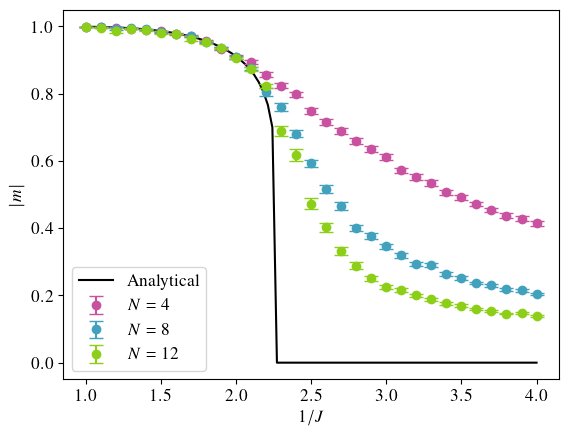

In [5]:
def do_bootstrap(J_inv: float, N: int) -> tuple[float, float]:
    sample = np.load(DIR / f"ensemble_{J_inv}_{N}.npy")
    m_sample = np.abs(sample.mean(axis=(1, 2)))
    tau = int(np.ceil(cp.integrated_autocorrelation(m_sample, fast=False)))
    m_sample = cp.blocking(m_sample, tau=tau)
    m_len = len(m_sample)
    if tau > 20:
        # Give a warning if some calculation did not work as expected and exclude from result
        print(f"Warning: tau = {tau} for J = {J_inv} N = {N}")
        return 0, 0
    return cp.Bootstrap(m_sample, m_len // 2, m_len // 2).estimate(lambda x: x)


colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.figure(1)
x = 1 / np.linspace(1, 4, 100)
plt.plot(1 / x, mean_mag_per_site(x), lw=1.5, color="black", label="Analytical")
plt.xlabel("$1 / J$")
plt.ylabel(r"$\abs{m}$")
for n in N:
    m = np.array([[*do_bootstrap(j_inv, n)] for j_inv in J_inv])
    with plt.rc_context(barstyle):
        plt.errorbar(J_inv, m[:, 0], yerr=m[:, 1], zorder=100, capsize=5, color=colors[n // 4 - 1], 
                     label=f"$N = {n}$")
plt.legend(loc="lower left")
plt.savefig(DIR / f"ex6.2_jscan.pdf")

## $\epsilon$ Scan

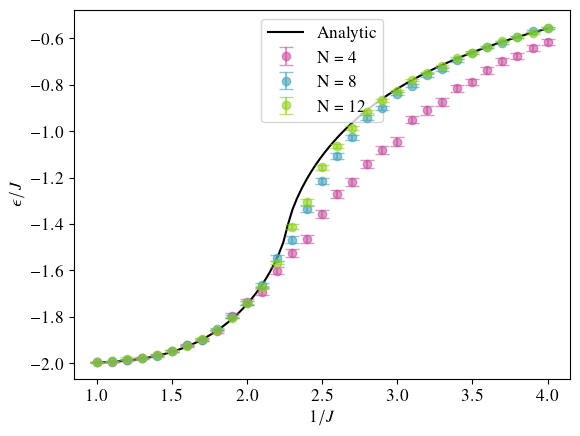

In [6]:
def do_e_bootstrap(J_inv: float, N: int) -> tuple[float, float]:
    sample = np.load(DIR / f"ensemble_{J_inv}_{N}.npy")
    model = cp.Ising2D(N, 1 / J_inv, 0)
    e = model.calc_energy(sample) / N**2
    tau = cp.integrated_autocorrelation(e, fast=False)
    if tau > 20:
        print(f"Warning: tau = {tau} for J = {J_inv} N = {N}")
        return 0, 0
    
    e = cp.blocking(e, tau=tau) 
    btrp = cp.Bootstrap(e, len(e) // 2, len(e) // 2)
    return btrp.estimate(lambda x: x)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.figure("e_scan")
x = np.linspace(1, 4, 100)
plt.plot(x, mean_energy_per_site(1 / x) * x, color="black", label="Analytic")
plt.xlabel(r"$1 / J$")
plt.ylabel(r"$\epsilon / J$")

for n in N:
    e = np.array([[*do_e_bootstrap(j_inv, n)] for j_inv in J_inv])

    with plt.rc_context(barstyle):
        plt.errorbar(J_inv, e[:, 0] * J_inv, yerr=e[:, 1] * J_inv, capsize=5, 
                     color=colors[n // 4 - 1], label=f"N = {n}", zorder=100, alpha=0.6)
    # plt.ylim((-2.001, -1.991))
plt.legend(loc="upper center")
plt.savefig(DIR / f"6.2_jsan_e.pdf")

# 3 Spin-Spin Correlation Function

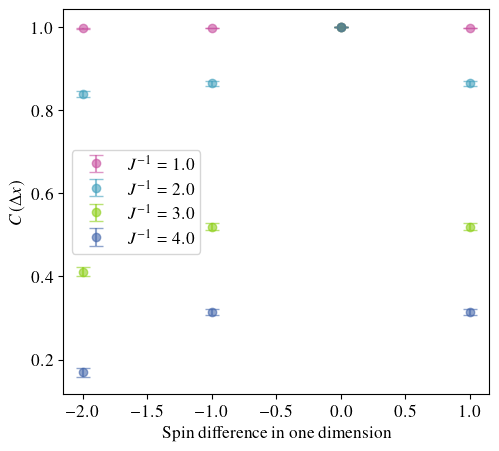

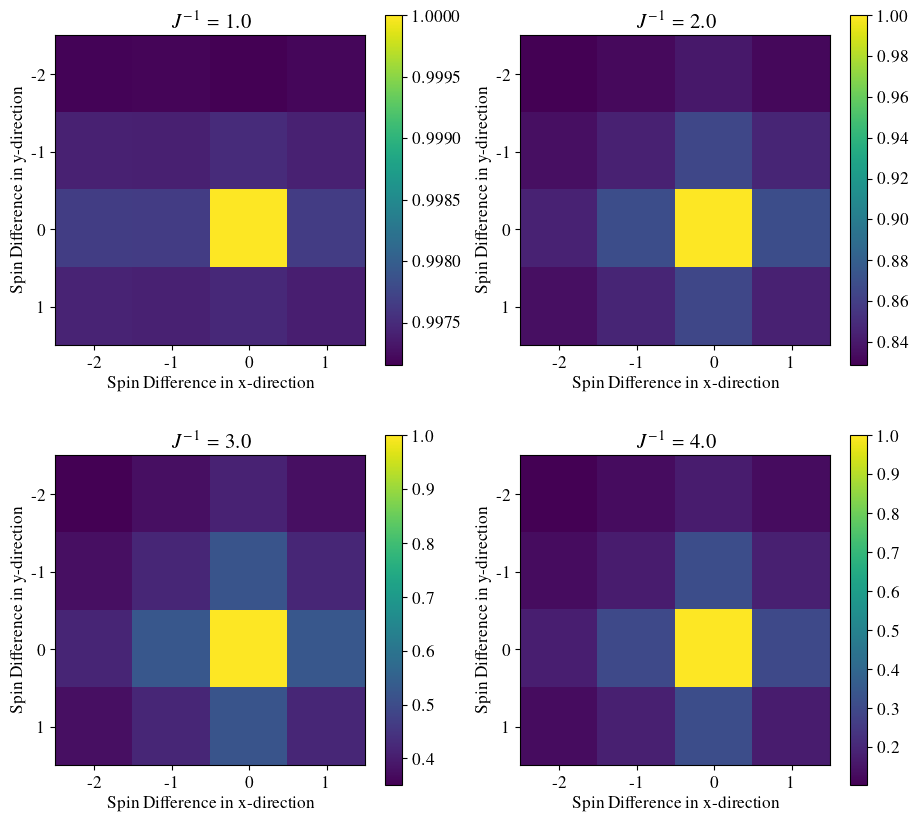

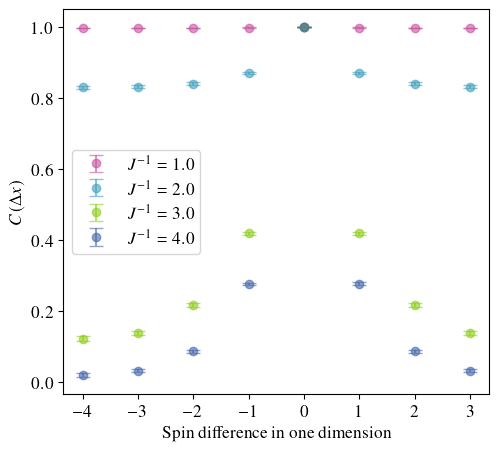

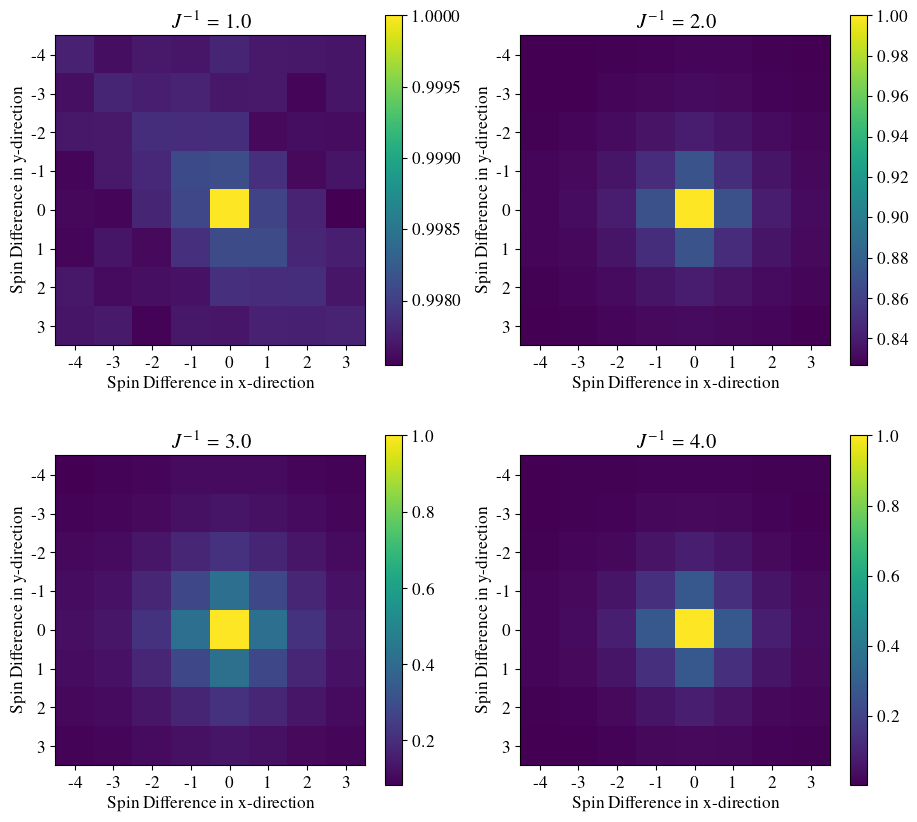

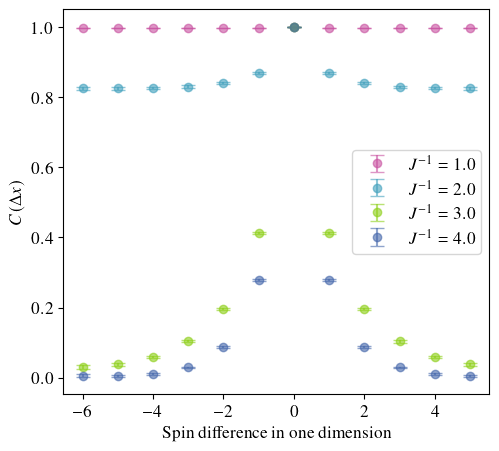

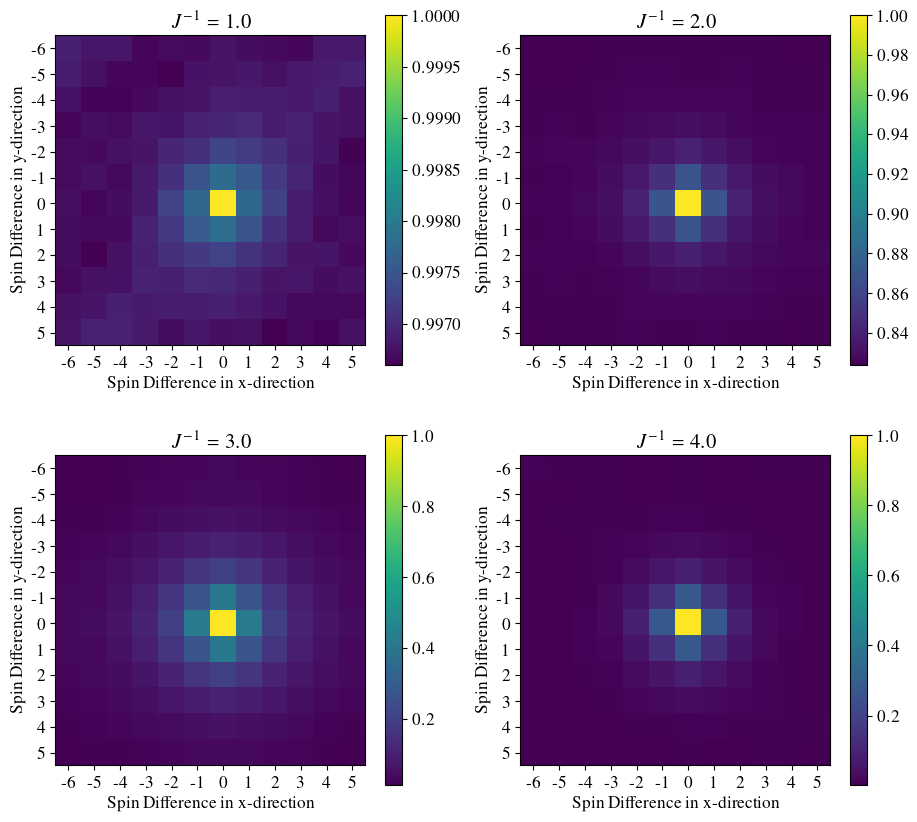

In [10]:
n = 12
j = 1.0
nr = np.arange(0, n, 1)

im = None
for n in [4, 8, 12]:
    for plot_index, j_inv in enumerate([1.0, 2.0, 3.0, 4.0]):
        sample = np.load(DIR / f"ensemble_{j_inv}_{n}.npy")

        c_sample = cp.mean_spin_spin_correlation(sample)

        # Bootstrap
        c_sample = c_sample.reshape(3000, n**2)
        c = np.zeros(n**2)  # this will be the bootstrapped results
        c_std = np.zeros_like(c)

        for i in range(n**2):
            data = c_sample[:, i]
            # tau = cp.integrated_autocorrelation(data, fast=False)
            # data = cp.blocking(data, fast=False)
            # print(data.shape)
            btrp = cp.Bootstrap(data, len(data) // 2, len(data))
            val, std = btrp.estimate(lambda x: x)
            c[i] = val
            c_std[i] = std

        # Reshape into 2d grid again
        c = c.reshape(n, n)
        c_std = c_std.reshape(n, n)
        if n == 8:
            c_1d = c[0, :]
            c_std_1d = c_std[0, :]
        else:
            c_1d = c[:, 0]
            c_std_1d = c_std[:, 0]

        # Move C(0) more to the middle
        move = int(np.round(n // 2, 0))
        c = np.roll(c, axis=(0, 1), shift=move)
        c_std = np.roll(c_std, axis=(0, 1), shift=move)

        c_1d = np.roll(c_1d, axis=0, shift=move)
        c_std_1d = np.roll(c_std_1d, axis=0, shift=move)

        ticks = np.array(range(n)) - move
        fig = plt.figure(n + 1, figsize=(5.5, 5))
        # plt.subplot(211)
        # plt.scatter(delta_x, c)
        with plt.rc_context(barstyle):
            plt.errorbar(ticks, c_1d, yerr=c_std_1d, capsize=5, label=f"$J^{{-1}} = {j_inv}$", alpha=0.6)
        plt.ylabel(r"$C(\Delta x)$")
        plt.xlabel(r"Spin difference in one dimension")
        plt.legend()
        fig.savefig(DIR / f"correlation_{n}.pdf")

        fig = plt.figure(n, figsize=(11, 10))
        plt.subplot(2, 2, plot_index + 1)
        plt.yticks(range(n), ticks)
        plt.xticks(range(n), ticks)
        plt.title(f"$J^{{-1}} = {j_inv}$")
        plt.xlabel("Spin Difference in x-direction")
        plt.ylabel("Spin Difference in y-direction")
        im = plt.imshow(c)
        plt.colorbar(im)
        fig.savefig(DIR / f"correlation_2d_{n}.pdf")

# 5. Correlation Length $\xi$

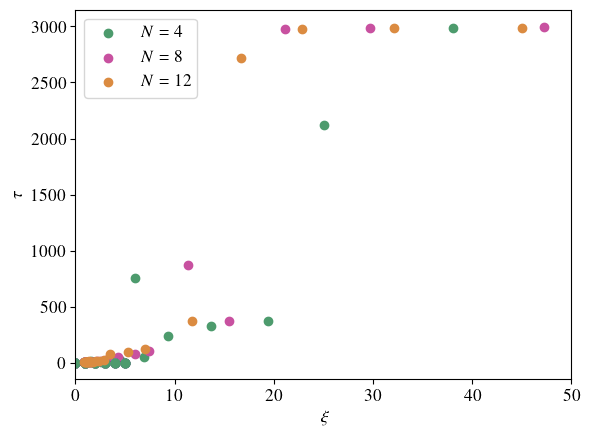

In [13]:

j_inv =  1 / 2 
n = 12

def calc_xi_and_tau(j_inv, n) -> tuple[float, float]:
   sample = np.load(DIR / f"ensemble_{j_inv}_{n}.npy")
   m = sample.mean(axis=(1, 2))
   tau = cp.integrated_autocorrelation(m, mean=0, fast=False)

   c_sample = cp.mean_spin_spin_correlation(sample)

   # Bootstrap
   c_sample = c_sample.reshape(3000, n**2)
   c = np.zeros(n**2)  # this will be the bootstrapped results
   c_std = np.zeros_like(c)

   for i in range(n**2):
      data = c_sample[:, i]
      btrp = cp.Bootstrap(data, len(data) // 4, len(data) // 10)
      val, std = btrp.estimate(lambda x: x)
      c[i] = val
      c_std[i] = std

   # Reshape into 2d grid again
   move = int(np.round(n // 2, 0))
   c = c.reshape(n, n)
   c_std = c_std.reshape(n, n)
   if n == 8:
      c_1d = c[0, :move]
      c_std_1d = c_std[0, :move]
   else:
      c_1d = c[:move, 0]
      c_std_1d = c_std[:move, 0]

   # move = 0
   # c_1d = np.roll(c_1d, axis=0, shift=move)
   # c_std_1d = np.roll(c_std_1d, axis=0, shift=move)
   delta_x = np.array(range(n))[:move] #- move
   plt.scatter(delta_x, c_1d)

   xi = -1 / np.gradient(np.log(c_1d), 1).mean()
   return xi, tau

for n in [4, 8, 12]:
   result = np.array([[*calc_xi_and_tau(j_inv, n)] for j_inv in J_inv])

   plt.scatter(result[:, 0], result[:, 1], label=f"$N = {n}$")
   plt.xlabel(r"$\xi$")
   plt.ylabel(r"$\tau$")
   plt.xlim((0, 50))
   plt.legend()
   plt.savefig(DIR / "tau_xi_wrong.pdf")

